# Libaray

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

from transformers import AutoTokenizer, AutoModel

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter  # TensorBoard
import os

/Users/aryan/Desktop/Academics /Semester 4/AI Software tools and techniques/model_checkpointing_cs203/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  #output with 2 labels as speciied
        )

    def forward(self, x):
        return self.model(x)

# Example input size (to be updated based on feature extraction method)
input_size = 10000  #based on the provided model architecture. 

# Initialize model
mlp_model_ = MLPClassifier(input_size)
print(mlp_model_)

# Count trainable parameters
print("\n\n############### Parameters ############### ")
total_params = sum(p.numel() for p in mlp_model_.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")


MLPClassifier(
  (model): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)


############### Parameters ############### 
Total Trainable Parameters: 5293122


# Model trained on bert embedding

### Loading Saved Embeddings

In [3]:
import numpy as np
import torch

# Load training embeddings and labels
X_train_imdb_bert = np.load("saved_bert_embed_imdb/IMDB_train_BERT_embeddings.npy")
y_train_imdb = np.load("saved_bert_embed_imdb/IMDB_train_labels.npy")

# Load validation embeddings and labels
X_val_imdb_bert = np.load("saved_bert_embed_imdb/IMDB_val_BERT_embeddings.npy")
y_val_imdb = np.load("saved_bert_embed_imdb/IMDB_val_labels.npy")

# Convert to PyTorch tensors
X_train_imdb_bert = torch.tensor(X_train_imdb_bert, dtype=torch.float32)
y_train_imdb = torch.tensor(y_train_imdb, dtype=torch.long)

X_val_imdb_bert = torch.tensor(X_val_imdb_bert, dtype=torch.float32)
y_val_imdb = torch.tensor(y_val_imdb, dtype=torch.long)

print(f"Train Tensor Shape: {X_train_imdb_bert.shape}")
print(f"Validation Tensor Shape: {X_val_imdb_bert.shape}")


Train Tensor Shape: torch.Size([40000, 768])
Validation Tensor Shape: torch.Size([10000, 768])


In [4]:
# Create DataLoaders
train_dataset = TensorDataset(X_train_imdb_bert, y_train_imdb)
val_dataset = TensorDataset(X_val_imdb_bert, y_val_imdb)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"IMDB BERT Training Features Shape: {X_train_imdb_bert.shape}")
print(f"IMDB BERT Validation Features Shape: {X_val_imdb_bert.shape}")


IMDB BERT Training Features Shape: torch.Size([40000, 768])
IMDB BERT Validation Features Shape: torch.Size([10000, 768])


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
input_size = X_train_imdb_bert.shape[-1]  
model_IMDB_bert = MLPClassifier(input_size).to(device)

# Load the saved model weights properly
checkpoint_path = "saved_models_bert/MLP_BERT_E6_Acc0.8707.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)  # Load the checkpoint dict
model_IMDB_bert.load_state_dict(checkpoint)  # Load weights into model

# Set model to evaluation mode for inference
model_IMDB_bert.eval()

print("Model successfully loaded!")

Model successfully loaded!


In [6]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_IMDB_bert.parameters(), lr=0.0001)

# DataLoader for training & validation
batch_size = 32
train_dataset = TensorDataset(X_train_imdb_bert, y_train_imdb)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_imdb_bert, y_val_imdb)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Setup TensorBoard
log_dir = "logs/imdb_bert"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# Training loop
epochs = 10
for epoch in range(epochs):
    model_IMDB_bert.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_IMDB_bert(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model_IMDB_bert.eval()
    correct = 0
    total = 0
    val_loss = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model_IMDB_bert(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    # Log losses & accuracy to TensorBoard
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
    writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

writer.close()
print("Training complete! ")

# Save the trained model_IMDB_bert
torch.save(model_IMDB_bert.state_dict(), "saved_models_bert/MLP_BERT_Final.pt")
print("Model saved successfully!")

# Run TensorBoard (use this command in terminal)
# tensorboard --logdir=logs/imdb_bert

Epoch [1/10] | Train Loss: 0.3067 | Val Loss: 0.2943 | Val Acc: 0.8770
Epoch [2/10] | Train Loss: 0.2878 | Val Loss: 0.2842 | Val Acc: 0.8816
Epoch [3/10] | Train Loss: 0.2784 | Val Loss: 0.2777 | Val Acc: 0.8830
Epoch [4/10] | Train Loss: 0.2731 | Val Loss: 0.2781 | Val Acc: 0.8822
Epoch [5/10] | Train Loss: 0.2674 | Val Loss: 0.2714 | Val Acc: 0.8854
Epoch [6/10] | Train Loss: 0.2623 | Val Loss: 0.2664 | Val Acc: 0.8874
Epoch [7/10] | Train Loss: 0.2575 | Val Loss: 0.2692 | Val Acc: 0.8867
Epoch [8/10] | Train Loss: 0.2527 | Val Loss: 0.2630 | Val Acc: 0.8899
Epoch [9/10] | Train Loss: 0.2490 | Val Loss: 0.2620 | Val Acc: 0.8885
Epoch [10/10] | Train Loss: 0.2443 | Val Loss: 0.2664 | Val Acc: 0.8883
Training complete! 
Model saved successfully!


# bag of words (BoW)

In [7]:
# Load the IMDB dataset
imdb_url = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"
imdb_df = pd.read_csv(imdb_url)

# Convert sentiment to numerical labels ('positive' -> 1, 'negative' -> 0)
imdb_df['label'] = imdb_df['sentiment'].apply(lambda x: 1 if x.lower() == 'positive' else 0)

# Split dataset (80% training, 20% validation)
imdb_train_df, imdb_val_df = train_test_split(imdb_df, test_size=0.2, random_state=42)

# Extract text and labels
imdb_train_texts = imdb_train_df['review']
imdb_train_labels = imdb_train_df['label']
imdb_val_texts = imdb_val_df['review']
imdb_val_labels = imdb_val_df['label']

# Initialize CountVectorizer for Bag-of-Words representation
vectorizer = CountVectorizer(max_features=10000)  # Limit vocabulary size to 10,000
X_train_imdb = vectorizer.fit_transform(imdb_train_texts).toarray()
X_val_imdb = vectorizer.transform(imdb_val_texts).toarray()

# Convert features and labels to PyTorch tensors
X_train_imdb_bow = torch.tensor(X_train_imdb, dtype=torch.float32)
X_val_imdb_bow = torch.tensor(X_val_imdb, dtype=torch.float32)
y_train_imdb = torch.tensor(imdb_train_labels.values, dtype=torch.long)
y_val_imdb = torch.tensor(imdb_val_labels.values, dtype=torch.long)

print(f"IMDB BoW Training Features Shape: {X_train_imdb.shape}")
print(f"IMDB BoW Validation Features Shape: {X_val_imdb.shape}")


IMDB BoW Training Features Shape: (40000, 10000)
IMDB BoW Validation Features Shape: (10000, 10000)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
input_size = 10000  # This should match the feature extraction method (BoW feature size)
model_IMDB_bow = MLPClassifier(input_size).to(device)

# Load the saved model weights
checkpoint_path = "saved_models_bow/MLP_BoW_E8_Acc0.8006.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)  # Load on correct device
model_IMDB_bow.load_state_dict(checkpoint)  # Load weights

# Set model to evaluation mode for inference
model_IMDB_bow.eval()

print("Model successfully loaded!")

Model successfully loaded!


In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_IMDB_bow.parameters(), lr=0.0001)

# DataLoader for training & validation
batch_size = 32
train_dataset = TensorDataset(X_train_imdb_bow, y_train_imdb)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_imdb_bow, y_val_imdb)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Setup TensorBoard
log_dir = "logs/imdb_bow"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# Training loop
epochs = 10
for epoch in range(epochs):
    model_IMDB_bow.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_IMDB_bow(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model_IMDB_bow.eval()
    correct = 0
    total = 0
    val_loss = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model_IMDB_bow(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    # Log losses & accuracy to TensorBoard
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
    writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

writer.close()
print("Training complete! 🎉")

# Save the trained model_IMDB_bow
torch.save(model_IMDB_bow.state_dict(), "saved_models_bow/MLP_BoW_Final.pt")
print("Model saved successfully!")

# Run TensorBoard (use this command in terminal)
# tensorboard --logdir=logs/imdb_bow

Epoch [1/10] | Train Loss: 4.9383 | Val Loss: 0.4532 | Val Acc: 0.8262
Epoch [2/10] | Train Loss: 0.3288 | Val Loss: 0.2656 | Val Acc: 0.8959
Epoch [3/10] | Train Loss: 0.2281 | Val Loss: 0.2549 | Val Acc: 0.9015
Epoch [4/10] | Train Loss: 0.1856 | Val Loss: 0.2764 | Val Acc: 0.8945
Epoch [5/10] | Train Loss: 0.1447 | Val Loss: 0.3101 | Val Acc: 0.8889
Epoch [6/10] | Train Loss: 0.0916 | Val Loss: 0.3797 | Val Acc: 0.8840
Epoch [7/10] | Train Loss: 0.0421 | Val Loss: 0.5008 | Val Acc: 0.8809
Epoch [8/10] | Train Loss: 0.0132 | Val Loss: 0.6579 | Val Acc: 0.8804
Epoch [9/10] | Train Loss: 0.0153 | Val Loss: 0.8995 | Val Acc: 0.8653
Epoch [10/10] | Train Loss: 0.0114 | Val Loss: 0.7547 | Val Acc: 0.8792
Training complete! 🎉
Model saved successfully!


/var/folders/r4/6gw7r2mj0t5g7qss7k7160940000gn/T/ipykernel_31661/1307470804.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)


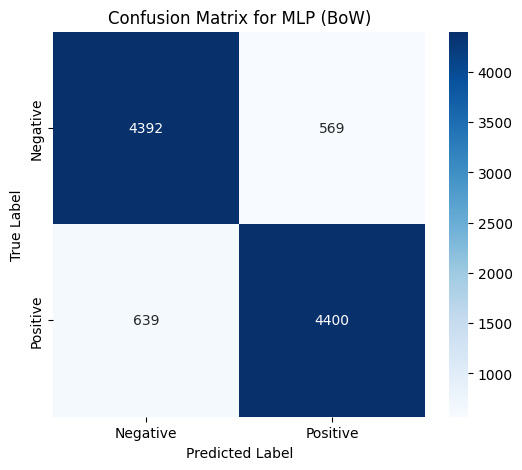


Classification Report for MLP (BoW):
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      4961
           1       0.89      0.87      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



/var/folders/r4/6gw7r2mj0t5g7qss7k7160940000gn/T/ipykernel_31661/1307470804.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)


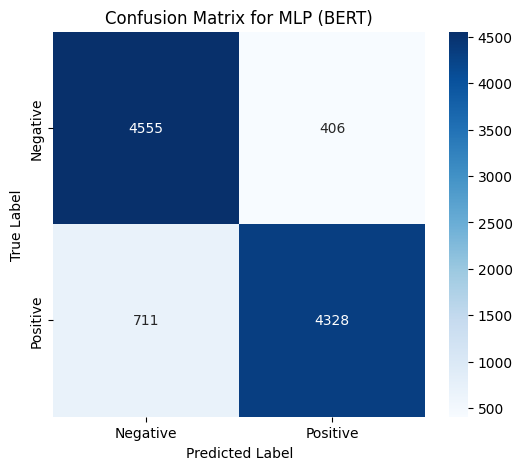


Classification Report for MLP (BERT):
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      4961
           1       0.91      0.86      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [11]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report



# Define function to load model and compute predictions
def evaluate_model(model_path, X_val, model_name="Model"):
    # Load model
    input_size = X_val.shape[1]
    model = MLPClassifier(input_size)
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()

    # Convert to tensor
    X_val = torch.tensor(X_val, dtype=torch.float32)

    # Get predictions
    with torch.no_grad():
        outputs = model(X_val)
        predictions = torch.argmax(outputs, dim=1).numpy()

    # Compute confusion matrix
    cm = confusion_matrix(y_val_imdb.numpy(), predictions)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {model_name}:\n", classification_report(y_val_imdb.numpy(), predictions))



# Evaluate BoW Model
evaluate_model("saved_models_bow/MLP_BoW_Final.pt", X_val_imdb_bow, "MLP (BoW)")

# Evaluate BERT Model
evaluate_model("saved_models_bert/MLP_BERT_Final.pt", X_val_imdb_bert, "MLP (BERT)")


In [ ]:
!tensorboard --logdir=logs/imdb_bert

^C
